# Why EOReader?

EOReader has been designed to:
- ✅ **simplify and harmonize the use of satellite data**. 
   - load data **sensor-agnostically**
   - wide **range of supported sensors**
   - make algorithms **easy to update** with new sensors
   - **automatic** preprocessing and spectral index computation
- ✅ **increase the reliability** of the production tools
- ✅ **be opensource** and **comunity friendly**

---

Let's illustrate this with an example.
The purpose of this notebook will be to load a **NIR band in reflectance** from different products: an archived Landsat-9, a Pléiades and an archived Sentinel-2.

We will start to see how it's done first with `eoreader` and then with only `rasterio`.
We could have compared also to how it's done with `rioxarray`, but this will be for another time.

## Imports

In [1]:
import os
import numpy as np
import rasterio
import eoreader
from eoreader.reader import Reader
from eoreader.bands import NIR
from rasterio.plot import show, adjust_band
from matplotlib import pyplot as plt

## Data preparation

Link the paths of the three different products.

In [2]:
# Base folder
prod_folder = os.path.join("/home", "ds2_db3", "CI", "eoreader", "optical")

# Landsat-9 OLI-TIRS collection 2 (archived in a tar file)
l9_path = os.path.join(prod_folder, "LC09_L1TP_200030_20220201_20220201_02_T1.tar")

# Pléiades, as a folder (extracted data)
pld_path = os.path.join(prod_folder, "IMG_PHR1A_PMS_001")

# Sentinel-2 L2A (archived in a zip file)
s2_path = os.path.join(prod_folder, "S2A_MSIL1C_20200824T110631_N0209_R137_T30TTK_20200824T150432.SAFE.zip")

# Group all these paths
paths = [l9_path, pld_path, s2_path]

## EOReader

With EOReader, you can easily access archived and extracted data, without paying attention at where everything is stored.

By default, your band nodata is set and the data converted to reflectance.

Everything is done with xarray, so you can easily access the plot function.

And last but not least, you just can loop over the paths, like if they were of the same kind!

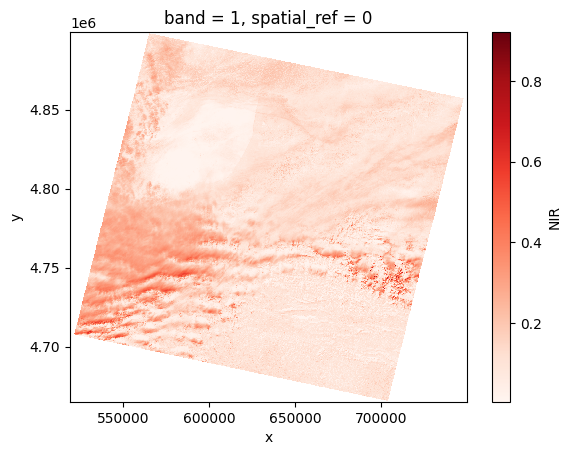

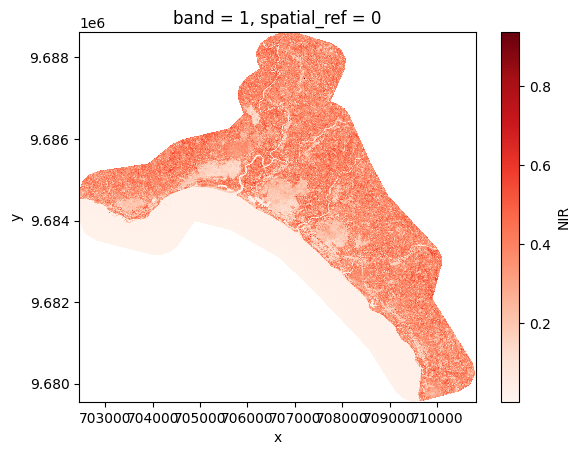

In [ ]:
%matplotlib inline
reader = Reader()
for path in paths:
    # Open the product
    prod = reader.open(path)
    
    # Load NIR
    nir = prod.load(NIR)[NIR]
    
    # Plot
    nir[:, ::5, ::5].plot(cmap="Reds")
    plt.show()

## Rasterio

For rasterio, of course the code will be a bit overly specific and complex as this library is way more generic than EOReader.

### NIR for Landsat-9

For Landsat-9, the NIR band is the 5th.

⚠️The Landsat-9 product is archived in a tar file, so be careful how you read the NIR file.

In [ ]:
l9_nir_path = rf"tar://{l9_path}!LC09_L1TP_200030_20220201_20220201_02_T1_B5.TIF"

with rasterio.open(l9_nir_path) as l9_nir_ds:
    l9_nir = l9_nir_ds.read()
    l9_tr = l9_nir_ds.transform

Here we have the Landsat-9 band as a numpy array, but it is not in reflectance and the nodata is not set.

In [ ]:
# First convert the band to float (as we want reflectance values and why not nans in place of nodata)
l9_nir = l9_nir.astype(np.float32)

# Set nodata, for landsat it is where the band is null (before converting to reflectance!)
l9_nir = np.where(l9_nir==0, np.nan, l9_nir)

# Convert to reflectance
# We can look in the metadata file (LC09_L1TP_200030_20220201_20220201_02_T1_MTL.xml) inside the zip to go faster for this specific band.
# However, you will need to repeat this operation for any other band or product
# Or set it in stone, but be careful as the specification may change...
l9_nir_c_add = -0.100000
l9_nir_c_mul = 2.0000E-05
l9_nir_refl = l9_nir * l9_nir_c_mul + l9_nir_c_add

In [ ]:
show(adjust_band(l9_nir_refl), transform=l9_tr, cmap='Reds')

### NIR for Pleiades

For Pleiades, the NIR band is the 4th.

The Pleaides product is a stack, so only read the 4th band. 

⚠️It is also best to read the DIMAP.xml file rather than the .JP2 as the product may be tiled.

In [ ]:
pld_nir_path = os.path.join(pld_path, "DIM_PHR1A_PMS_202005110231585_ORT_5547047101.XML")

with rasterio.open(pld_nir_path) as pld_nir_ds:
    pld_nir = pld_nir_ds.read()
    pld_tr = pld_nir_ds.transform

We still need to set the nodata. 

In [ ]:
# Convert the band to float for consistency
pld_nir = pld_nir.astype(np.float32)

# Set nodata, for landsat it is where the band is null
pld_nir = np.where(pld_nir==0, np.nan, pld_nir)

⚠️ And we are not lucky, according to the metadata file, the Pleiades data hasn't been ordered in reflectance!
Indeed, we can find `<RADIOMETRIC_PROCESSING>BASIC</RADIOMETRIC_PROCESSING>` in the metadata file, that means we need to convert the data from DN to reflectance.
This is too long to be done here, first we need to convert DN to TOA radiance, then convert it to TOA reflectance, as seen in the [Appendix D of the Pleiades User Guide](https://www.intelligence-airbusds.com/automne/api/docs/v1.0/document/download/ZG9jdXRoZXF1ZS1kb2N1bWVudC01NTY0Mw==/ZG9jdXRoZXF1ZS1maWxlLTU1NjQy/airbus-pleiades-imagery-user-guide-15042021.pdf#page=94)

In [ ]:
show(adjust_band(pld_nir), transform=pld_tr, cmap='Reds')


### NIR for Sentinel-2

For Sentinel-2, there are two NIR bands, one with a spatial resolution of 10 meters (`8A`) but with a lower spectral resolution than the 20m NIR band (`08`). So if you work at 20m of resolution it will be better to load the `08` band.

⚠️The Sentinel-2 product is archived in a zip file, so be careful how you read the NIR file.

⚠️The Sentinel-2 bands are not easy to retrieve, you should look in the `GRANULE` and into the `IMG_DATA` folder.
This is product specific!

In [ ]:
s2_nir_path = os.path.join(
    f"zip://{s2_path}",
    "S2A_MSIL1C_20200824T110631_N0209_R137_T30TTK_20200824T150432.SAFE!",
    "GRANULE",
    "L1C_T30TTK_A027018_20200824T111345",
    "IMG_DATA",
    "T30TTK_20200824T110631_B08.jp2"
)

with rasterio.open(s2_nir_path) as s2_nir_ds:
    s2_nir = s2_nir_ds.read()
    s2_tr = s2_nir_ds.transform

Set the nodata and convert into reflectance!

⚠️⚠️⚠️
This seems easy fore Sentinel-2 data, but pay attention that if the product has been acquired after 25/01/2022 (with the [processing baseline](https://sentinel.esa.int/web/sentinel/technical-guides/sentinel-2-msi/processing-baseline) 04.00), an offset has been added!

And if the processing baseline is less than 02.07 for L2A products (L2Ap) (before 06/11/2018), the bands are not geocoded and you need to do it manually...

In [ ]:
# First convert the band to float (as we want reflectance values and why not nans in place of nodata)
s2_nir = s2_nir.astype(np.float32)

# Set nodata, for Sentinel-2 it is where the band is null
s2_nir = np.where(s2_nir==0, np.nan, s2_nir)

# Convert to reflectance
s2_nir_c_add = 0  # This changes with baseline 04.00!
s2_nir_c_mul = 1/10000
s2_nir_refl = s2_nir * s2_nir_c_mul + s2_nir_c_add

In [ ]:
show(adjust_band(s2_nir_refl), transform=s2_tr, cmap='Reds')

## Overview of the simplifications

What you get in exchange of a bit of speed:

![pro/contras](https://zupimages.net/up/22/27/6yz0.png)
